# Linear Regression on Bank Marketing Database

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing
    
This one is very famous. Given a set of features, find the clients more suitable to make a term deposit.

In [26]:
# Better than "print" on Jupyter Notebooks
from IPython.display import display

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.graphics.gofplots import qqplot

import sklearn.preprocessing as pre
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

## Load file and check data

In [2]:
raw = pd.read_csv("bank.csv", sep=";")

display(raw.head())
display(raw.describe().T)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


,count,mean,std,min,25%,50%,75%,max
age,4521.0,41.170095,10.576211,19.0,33.0,39.0,49.0,87.0
balance,4521.0,1422.657819,3009.638142,-3313.0,69.0,444.0,1480.0,71188.0
day,4521.0,15.915284,8.247667,1.0,9.0,16.0,21.0,31.0
duration,4521.0,263.961292,259.856633,4.0,104.0,185.0,329.0,3025.0
campaign,4521.0,2.793630,3.109807,1.0,1.0,2.0,3.0,50.0
pdays,4521.0,39.766645,100.121124,-1.0,-1.0,-1.0,-1.0,871.0
previous,4521.0,0.542579,1.693562,0.0,0.0,0.0,0.0,25.0


## Data preparation

Job has too many categories, so we simplify it for now. Don't do that before look at your data.

In [3]:
# Remove previous contacted clients
raw = raw[raw.pdays == -1]

# Reduce the number of classes in "jobs"
to_job_type = {'admin.': 'white collar',
               'entrepreneur': 'white collar',
               'management': 'white collar',
               'self-employed': 'white collar',
               'blue-collar': 'blue collar',
               'services': 'blue collar',
               'technician': 'blue collar'}
raw['job_type'] = raw['job'].map(to_job_type).fillna('unknown')

## Mosaics - View Relevance on Categorical Variables

A [mosaic plot](https://en.wikipedia.org/wiki/Mosaic_plot) show the proportion of each category. A visual inspection show unbalanced categories an if the feature is a potentially

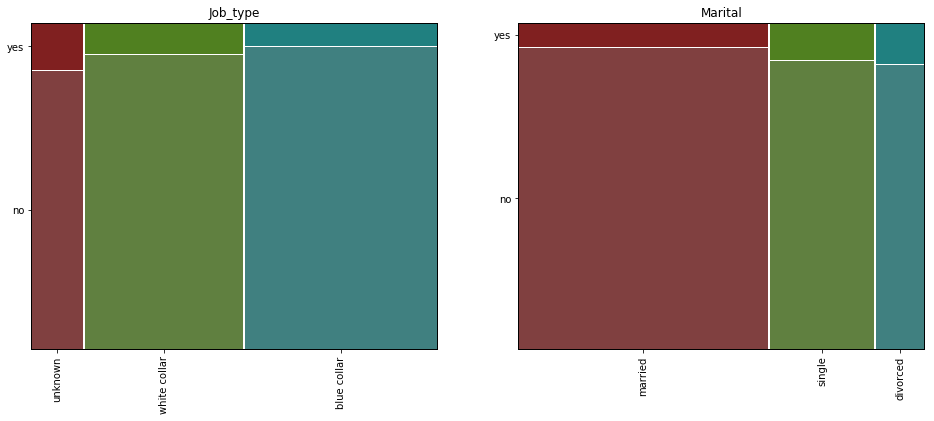

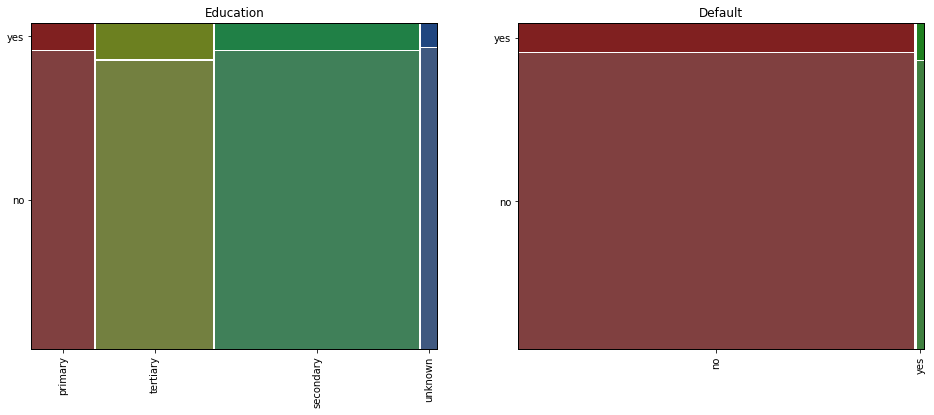

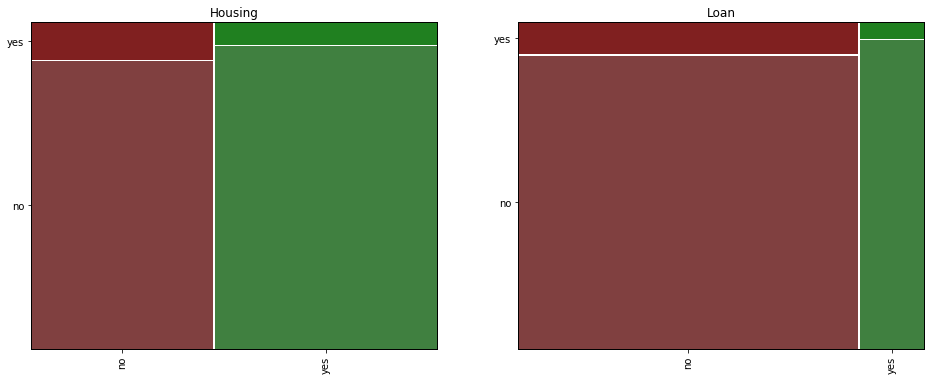

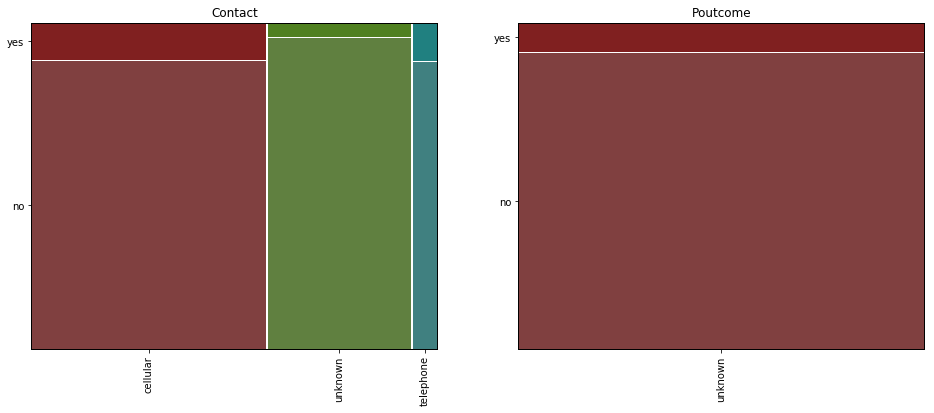

In [4]:
def mosaic_for(chart, feature_name):
    mosaic(raw, [feature_name, 'y'], 
           ax=chart,
           title=feature_name.capitalize(),
           label_rotation=[90, 0],
           labelizer=lambda k: '') 
    
fig, charts = plt.subplots(1, 2, figsize=(16, 6))
mosaic_for(charts[0], 'job_type')
mosaic_for(charts[1], 'marital')

fig, charts = plt.subplots(1, 2, figsize=(16, 6))
mosaic_for(charts[0], 'education')
mosaic_for(charts[1], 'default')

fig, charts = plt.subplots(1, 2, figsize=(16, 6))
mosaic_for(charts[0], 'housing')
mosaic_for(charts[1], 'loan')

fig, charts = plt.subplots(1, 2, figsize=(16, 6))
mosaic_for(charts[0], 'contact')
mosaic_for(charts[1], 'poutcome')

# Q-Q Plot - View Relevance on Continuous Variables

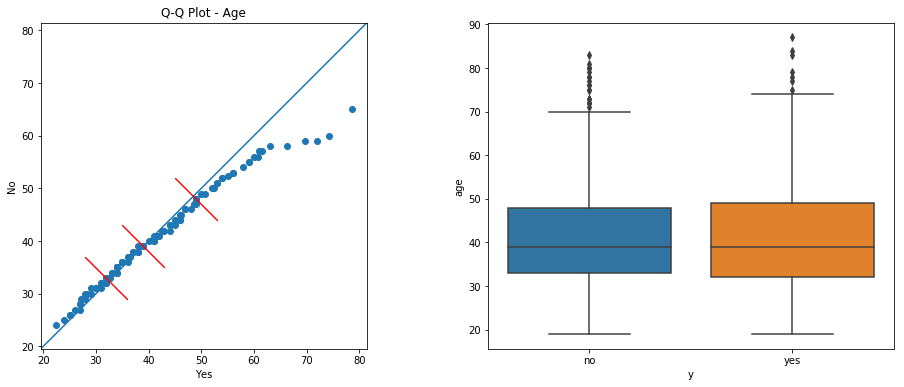

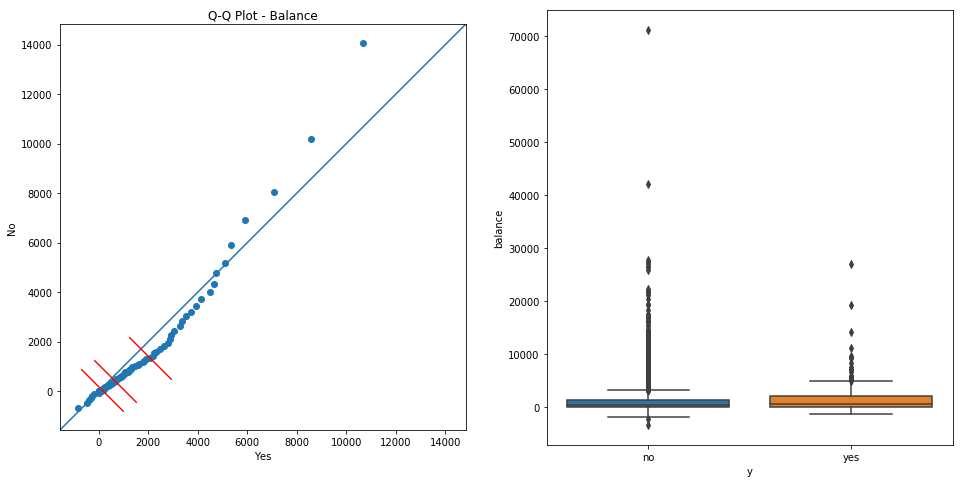

In [23]:
def qq_plot(x, y, ax, margin=0.05, title=None):
    # 1 to 99 removes extreme outliers, 0 - 100 would give min and max
    quantiles = np.linspace(1, 99, 99) 
    x_perc = np.percentile(x, q=quantiles)
    y_perc = np.percentile(y, q=quantiles)

    min_perc = min(min(x_perc), min(y_perc))
    max_perc = max(max(x_perc), max(y_perc))
    margin_perc = (max_perc - min_perc) * margin
    min_max = (min_perc - margin_perc, max_perc + margin_perc)
    
    chart1.scatter(x_perc, y_perc)
    chart1.plot(min_max, min_max)
    quartiles_x = [x_perc[24], x_perc[49], x_perc[74]]
    quartiles_y = [y_perc[24], y_perc[49], y_perc[74]]
    chart1.plot(quartiles_x, quartiles_y, marker=(2, 2, 45), color='red', markersize=60, linestyle="None")
    chart1.set_xlim(min_max)
    chart1.set_ylim(min_max)
    chart1.set_xlabel('Yes')
    chart1.set_ylabel('No')
    chart1.set_aspect('equal')
    if title:
        chart1.set_title('Q-Q Plot - ' + title)
    else:
        chart1.set_title('Q-Q Plot')

fig, [chart1, chart2] = plt.subplots(1, 2, figsize=(16, 6))

age_yes = raw['age'][raw['y'] == 'yes']
age_no = raw['age'][raw['y'] == 'no']

qq_plot(age_yes, age_no, ax=chart1, title='Age')
sns.boxplot(data=raw, x='y', y='age', ax=chart2)


fig, [chart1, chart2] = plt.subplots(1, 2, figsize=(16, 8))

balance_yes = raw['balance'][raw['y'] == 'yes']
balance_no = raw['balance'][raw['y'] == 'no']

qq_plot(balance_yes, balance_no, ax=chart1, title='Balance')
sns.boxplot(data=raw, x='y', y='balance', ax=chart2);

## Dummy Variables (One Hot Encoding)

We need to transform categorical variables in multiple features with 0, 1.

In [35]:
desired_columns = ['age', 'job_type', 'marital', 'education', 'balance', 'housing', 'loan', 'default']
dummy_columns = ['job_type', 'marital', 'education', 'housing', 'loan', 'default']
features = pd.get_dummies(raw[desired_columns], columns=dummy_columns)

display(features.head())

,age,balance,job_type_blue collar,job_type_unknown,job_type_white collar,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,housing_no,housing_yes,loan_no,loan_yes,default_no,default_yes
0,30,1787,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0
3,30,1476,0,0,1,0,1,0,0,0,1,0,0,1,0,1,1,0
4,59,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0
7,39,147,1,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0
8,41,221,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0


In [36]:
# Mapping "yes", "no" to 1 and 0, default to 0 if no info
target = raw['y'].map({'no': 0, 'yes': 1}).fillna(0)
display(len(target[target == 0]))
display(len(target[target == 1]))

3368

337

## Model Performance

Using Precision, Recall and F1-Score

In [37]:
scaler = pre.StandardScaler()
classifier = LogisticRegression()
model = Pipeline([('scaler', scaler), ('classifier', classifier)])

### AUROC - Area Under Receiving Operating Characteristc

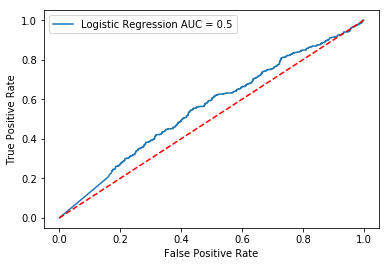

In [41]:
model.fit(features, target)
auc = roc_auc_score(target, model.predict(features))

probas = model.named_steps.classifier.predict_proba(features)
fpr, tpr, thresholds = roc_curve(target, probas[:, 1])

fig, chart = plt.subplots()

# ROC
chart.plot(fpr, tpr, label='Logistic Regression AUC = {}'.format(auc))
# Reference line
chart.plot([0, 1], [0, 1], "r--")

chart.set_xlabel("False Positive Rate")
chart.set_ylabel("True Positive Rate")
chart.legend()


In [43]:
scores = cross_validate(model, features, target, cv=10,
                        scoring=['precision_macro', 'recall_macro', 'f1_macro'],
                        return_train_score=False)

display(scores['test_precision_macro'].mean())
display(scores['test_recall_macro'].mean())
display(scores['test_f1_macro'].mean())

/home/ronie/anaconda3/envs/saco-de-maldades/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ronie/anaconda3/envs/saco-de-maldades/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ronie/anaconda3/envs/saco-de-maldades/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ronie/anaconda3/envs/saco-de-maldades/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predic

0.5

## Feature Importance

For Linear Regression the feature importance are just the coefficients. However, if and only if the features are **normalized**.

In [11]:
scaled_features = pre.robust_scale(features)
model = LogisticRegression()
model.fit(scaled_features, target)

importance = abs(model.coef_[0])
importance = pd.DataFrame(importance, columns=['importance'], index=features.columns)
importance = importance.sort_values(by='importance', ascending=False)
display(importance)

,importance
job_type_blue collar,0.890082
job_type_white collar,0.740303
marital_married,0.356881
loan_yes,0.344532
loan_no,0.344532
education_unknown,0.327970
job_type_unknown,0.325037
education_tertiary,0.270371
marital_divorced,0.196619
housing_no,0.195149


## Selecting Features

Reducing features using RFE (Recursive Feature Elimination) and Cross Validation. Let's see if the importance above makes sense.

In [12]:
selector = RFECV(LogisticRegression(), cv=10)

model  = Pipeline([('scaler', pre.RobustScaler()),
                   ('selector', selector)])

model.fit(scaled_features, target)

selector = model.named_steps.selector

display(selector.score(features, target))
display(selector.support_)
display(selector.ranking_)

best_columns = features.columns[selector.support_]
display(best_columns)

0.10661268556005399

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Index(['age', 'balance', 'job_type_blue collar', 'job_type_unknown',
       'job_type_white collar', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'housing_no', 'housing_yes',
       'loan_no', 'loan_yes', 'default_no', 'default_yes', 'poutcome_unknown'],
      dtype='object')

In [13]:
scaler = pre.StandardScaler()
classifier = LogisticRegression()
model = Pipeline([('scaler', scaler), ('classifier', classifier)])
scores = cross_validate(model, features[best_columns], target, cv=10,
                        scoring=['precision_macro', 'recall_macro', 'f1_macro'],
                        return_train_score=False)

display(scores['test_precision_macro'].mean())
display(scores['test_recall_macro'].mean())
display(scores['test_f1_macro'].mean())

/home/ronie/anaconda3/envs/saco-de-maldades/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ronie/anaconda3/envs/saco-de-maldades/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ronie/anaconda3/envs/saco-de-maldades/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ronie/anaconda3/envs/saco-de-maldades/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predic

0.45452197941153305

0.5

0.47617743452259803